In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import matplotlib as mpl

# Add function path
original_path = os.getcwd()
os.chdir(original_path)
function_path = './functions/'
sys.path.append(function_path)

# Import custom functions
from analysis_function import *
from kcc_constrain_function import *
from Plot_function import *
from f1_0_H_sum_multi_region_constrain import *
from f_IMP import *
from f_schemes import *
from ar6_area_weighted_cont_global import *


In [3]:
path = './saved_data/'

def load_xr_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

obs_all = load_xr_pickle(path + '0.1.HadCRUT5.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

obs_200runs_all = load_xr_pickle(path + '0.2.HadCRUT5.200runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

mod_all = load_xr_pickle(path + '0.4.Smoothed_His-ALL.25mods.mean.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_171years_1850-2020.pkl')

mod_sub_forcing = load_xr_pickle(path + '0.4.Smoothed_His-ANT.NAT.GHG.OA.10mods.mean.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_171years_1850-2020.pkl')

mod_all = xr.concat([mod_all,mod_sub_forcing],dim = 'forcing')

ln_mod_all = load_xr_pickle(path + '0.3.Large_ensembles.320runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_251years_1850-2100.pkl')

mod_45_pseudo = load_xr_pickle(path + '0.5.pseudo-model.15mod.run1-3.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_176years_1850-2025.pkl')

print_xarray_info(obs_all, obs_200runs_all, mod_all, ln_mod_all, mod_45_pseudo)


Array 1:
  Sizes: Frozen({'year': 175, 'region': 54})
  Coords: ['realization', 'year', 'region', 'abbrevs', 'names']

Array 2:
  Sizes: Frozen({'runs': 200, 'year': 175, 'region': 54})
  Coords: ['runs', 'year', 'region', 'abbrevs', 'names']

Array 3:
  Sizes: Frozen({'forcing': 5, 'model_name': 25, 'year': 176, 'region': 54})
  Coords: ['model_name', 'region', 'year', 'forcing', 'abbrevs', 'names']

Array 4:
  Sizes: Frozen({'model_run': 320, 'year': 251, 'region': 54})
  Coords: ['year', 'model_run', 'model_name', 'region', 'abbrevs', 'names']

Array 5:
  Sizes: Frozen({'model_run': 45, 'year': 176, 'region': 54})
  Coords: ['model_run', 'year', 'model_name', 'region', 'abbrevs', 'names']


In [8]:
from f_schemes import *

# -----------------------------------------
# Define time periods
# -----------------------------------------

ref_period = (1850, 1900)

warming_target_period1 = (2016, 2025)

# -----------------------------------------
# Define constraint schemes
# -----------------------------------------
region_groups = {
    'North and Central America': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR'],
    'South America': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA'],
    'Europe': ['NEU', 'WCE', 'EEU', 'MED'],
    'Africa': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS'],
    'Australasia': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
    'Antarctica': ['EAN', 'WAN'],
    'Global land': ['LSAT']
}

scheme_reg_lsat = generate_global_regional_target_constraint_pairs(region_groups, global_abbrev='LSAT')

scheme_reg_lsat

[{'target_reg': 'GIC', 'constrain_used_reg': ['GIC', 'LSAT']},
 {'target_reg': 'NWN', 'constrain_used_reg': ['NWN', 'LSAT']},
 {'target_reg': 'NEN', 'constrain_used_reg': ['NEN', 'LSAT']},
 {'target_reg': 'WNA', 'constrain_used_reg': ['WNA', 'LSAT']},
 {'target_reg': 'CNA', 'constrain_used_reg': ['CNA', 'LSAT']},
 {'target_reg': 'ENA', 'constrain_used_reg': ['ENA', 'LSAT']},
 {'target_reg': 'NCA', 'constrain_used_reg': ['NCA', 'LSAT']},
 {'target_reg': 'SCA', 'constrain_used_reg': ['SCA', 'LSAT']},
 {'target_reg': 'CAR', 'constrain_used_reg': ['CAR', 'LSAT']},
 {'target_reg': 'NWS', 'constrain_used_reg': ['NWS', 'LSAT']},
 {'target_reg': 'NSA', 'constrain_used_reg': ['NSA', 'LSAT']},
 {'target_reg': 'NES', 'constrain_used_reg': ['NES', 'LSAT']},
 {'target_reg': 'SAM', 'constrain_used_reg': ['SAM', 'LSAT']},
 {'target_reg': 'SWS', 'constrain_used_reg': ['SWS', 'LSAT']},
 {'target_reg': 'SES', 'constrain_used_reg': ['SES', 'LSAT']},
 {'target_reg': 'SSA', 'constrain_used_reg': ['SSA', 'L

In [10]:
#### global_region constraint
mod_all_new = xr.concat([mod_all.isel(region=slice(0, 46)), mod_all.isel(region=53)], dim = 'region')


constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all_new


mod_da = mod_all_new
obs_ar6 = obs_all
region_names = list(mod_da.names.values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['ALL']
constrain_forcing_names=['ALL']

scheme_pairs =  scheme_reg_lsat

prior_warm_ALL, post_warm_ALL, prior_smooth_ALL, post_smooth_ALL, obs_adj_ALL = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, reg_id = slice(0, len(region_names)), calc_smoothed = True, print_constraint_regions = True)


Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']
Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']
Processing region 2: N.E.North-America
 Constraining used region 2: ['NEN', 'LSAT']
Processing region 3: W.North-America
 Constraining used region 3: ['WNA', 'LSAT']
Processing region 4: C.North-America
 Constraining used region 4: ['CNA', 'LSAT']
Processing region 5: E.North-America
 Constraining used region 5: ['ENA', 'LSAT']
Processing region 6: N.Central-America
 Constraining used region 6: ['NCA', 'LSAT']
Processing region 7: S.Central-America
 Constraining used region 7: ['SCA', 'LSAT']
Processing region 8: Caribbean
 Constraining used region 8: ['CAR', 'LSAT']
Processing region 9: N.W.South-America
 Constraining used region 9: ['NWS', 'LSAT']
Processing region 10: N.South-America
 Constraining used region 10: ['NSA', 'LSAT']
Processing region 11: N.E.South-America
 Constraining used region 11: ['NES', 'LSAT']
Proc

### ALL = ANT + NAT, to constrain ANT and NAT

In [14]:
#### lsat_region constraint
constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all_new
mod_da = mod_all_new
obs_ar6 = obs_all
region_names = list(mod_da.names.values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['ANT', 'NAT']
constrain_forcing_names=['ANT', 'NAT']

prior_warm_ANT_NAT, post_warm_ANT_NAT, prior_smooth_ANT_NAT, post_smooth_ANT_NAT, obs_adj_ANT_NAT = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, reg_id = slice(0, len(region_names)), calc_smoothed = True, print_constraint_regions = True)



Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']
Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']
Processing region 2: N.E.North-America
 Constraining used region 2: ['NEN', 'LSAT']
Processing region 3: W.North-America
 Constraining used region 3: ['WNA', 'LSAT']
Processing region 4: C.North-America
 Constraining used region 4: ['CNA', 'LSAT']
Processing region 5: E.North-America
 Constraining used region 5: ['ENA', 'LSAT']
Processing region 6: N.Central-America
 Constraining used region 6: ['NCA', 'LSAT']
Processing region 7: S.Central-America
 Constraining used region 7: ['SCA', 'LSAT']
Processing region 8: Caribbean
 Constraining used region 8: ['CAR', 'LSAT']
Processing region 9: N.W.South-America
 Constraining used region 9: ['NWS', 'LSAT']
Processing region 10: N.South-America
 Constraining used region 10: ['NSA', 'LSAT']
Processing region 11: N.E.South-America
 Constraining used region 11: ['NES', 'LSAT']
Proc

### ALL = GHG + OA + NAT, to constrain GHG and OA and NAT

In [15]:
constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all_new
mod_da = mod_all_new
obs_ar6 = obs_all
region_names = list(mod_da.names.values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['GHG', 'OA', 'NAT']
constrain_forcing_names=['GHG', 'OA']

prior_warm_GHG_OA, post_warm_GHG_OA, prior_smooth_GHG_OA, post_smooth_GHG_OA, obs_adj_GHG_OA = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, reg_id = slice(0, len(region_names)), calc_smoothed = True, print_constraint_regions = True)


Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']
Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']
Processing region 2: N.E.North-America
 Constraining used region 2: ['NEN', 'LSAT']
Processing region 3: W.North-America
 Constraining used region 3: ['WNA', 'LSAT']
Processing region 4: C.North-America
 Constraining used region 4: ['CNA', 'LSAT']
Processing region 5: E.North-America
 Constraining used region 5: ['ENA', 'LSAT']
Processing region 6: N.Central-America
 Constraining used region 6: ['NCA', 'LSAT']
Processing region 7: S.Central-America
 Constraining used region 7: ['SCA', 'LSAT']
Processing region 8: Caribbean
 Constraining used region 8: ['CAR', 'LSAT']
Processing region 9: N.W.South-America
 Constraining used region 9: ['NWS', 'LSAT']
Processing region 10: N.South-America
 Constraining used region 10: ['NSA', 'LSAT']
Processing region 11: N.E.South-America
 Constraining used region 11: ['NES', 'LSAT']
Proc

### Concat results

In [18]:
prior_smooth_forcing_5 = xr.concat([prior_smooth_ALL, prior_smooth_ANT_NAT, prior_smooth_GHG_OA], dim = 'forcing')
post_smooth_forcing_5 = xr.concat([post_smooth_ALL, post_smooth_ANT_NAT, post_smooth_GHG_OA], dim = 'forcing')

prior_warm_forcing_5 = xr.concat([prior_warm_ALL, prior_warm_ANT_NAT, prior_warm_GHG_OA], dim = 'forcing')
post_warm_forcing_5 = xr.concat([post_warm_ALL, post_warm_ANT_NAT, post_warm_GHG_OA], dim = 'forcing')


In [19]:
scale_factor = 1.31

prior_warm_forcing_5_adj = scale_gaussian_percentiles(prior_warm_forcing_5, scale_factor=scale_factor)

post_warm_forcing_5_adj = scale_gaussian_percentiles(post_warm_forcing_5, scale_factor=scale_factor)

prior_smooth_forcing_5_adj = scale_gaussian_percentiles(prior_smooth_forcing_5, scale_factor=scale_factor)

post_smooth_forcing_5_adj = scale_gaussian_percentiles(post_smooth_forcing_5, scale_factor=scale_factor)

In [ ]:
prior_post_warm = xr.concat([prior_warm_forcing_5_adj, post_warm_forcing_5_adj], dim = 'scheme').assign_coords(scheme = ['prior', 'post'])
prior_post_smooth = xr.concat([prior_smooth_forcing_5_adj, post_smooth_forcing_5_adj], dim = 'scheme').assign_coords(scheme = ['prior', 'post'])

In [23]:
prior_post_smooth

path = './saved_data/'
file_name = '2.0.real_obs_constrain_prior_post_warming_2016-2025_ref.1850-1900.nc'
prior_post_warm.to_netcdf(path + file_name)

file_name = '2.1.real_obs_constrain_prior_post_smoothed_series_1850-2025_ref.1850-1900.nc'
prior_post_smooth.to_netcdf(path + file_name)

In [101]:
data = prior_post_warm.sel(scheme = 'post')
data['region'] = data['abbrevs']

# Create a reverse mapping: region -> group
region_to_group = {}
for group, regions in groups.items():
    for r in regions:
        region_to_group[r] = group

rows = []
for r in data['region'].values:
    row = {}
    # Add Group column first
    row['Continent'] = region_to_group.get(r, 'Other')
    row['Region'] = r  # region column
    for f in data['forcing'].values:
        q5 = data.sel(region= r, forcing=f, quantile='5th').item()
        qmean = data.sel(region=r, forcing=f, quantile='mean').item()
        q95 = data.sel(region=r, forcing=f, quantile='95th').item()
        # format as mean [5th, 95th]
        row[f] = f"{qmean:.1f} [{q5:.1f}, {q95:.1f}]"
    rows.append(row)

df = pd.DataFrame(rows)
# df['Region'] = data.abbrevs

# Optional: reorder columns to have Group first
cols = ['Continent', 'Region'] + [f for f in data['forcing'].values]
df = df[cols]

# Sort by Continent first
# df = df.sort_values(['Continent', 'Region']).reset_index(drop=True)

# Blank out repeated continent names
last_continent = None
for i, c in enumerate(df['Continent']):
    if c == last_continent:
        df.at[i, 'Continent'] = ''
    else:
        last_continent = c
df
# Save to CSV
df.to_csv("./saved_data/forcings5_warming_magnitude_summary.csv", index=False)
print("CSV saved with Group column.")

CSV saved with Group column.


In [39]:
global_constrained_warming = prior_post_warm.sel(scheme = 'post', region = 46)
global_constrained_warming

<xarray.DataArray 'prior_warming' (forcing: 5, quantile: 3)> Size: 120B
array([[ 1.5737789 ,  1.37298772,  1.77457009],
       [ 1.49839606,  1.30060487,  1.69618726],
       [ 0.04468603, -0.09223505,  0.18160711],
       [ 1.76408699,  1.15099901,  2.37717498],
       [-0.30458514, -0.98018858,  0.37101831]])
Coordinates:
    region       int64 8B 46
  * forcing      (forcing) <U3 60B 'ALL' 'ANT' 'NAT' 'GHG' 'OA'
  * quantile     (quantile) <U4 48B 'mean' '5th' '95th'
    abbrevs      <U4 16B 'LSAT'
    names        <U25 100B 'Global Land'
    realization  int64 8B 100
    scheme       <U5 20B 'post'

### Area-weighted global mean


In [37]:
global_weighted_warming = compute_global_area_average(post_warm_forcing_5_adj)
global_weighted_warming

<xarray.DataArray (forcing: 5, quantile: 3)> Size: 120B
array([[ 1.61659628,  1.1896386 ,  2.04355397],
       [ 1.51380652,  1.12791253,  1.89970051],
       [ 0.05963401, -0.1461748 ,  0.26544281],
       [ 1.84300231,  1.20311157,  2.48289305],
       [-0.36014339, -1.06326519,  0.34297841]])
Coordinates:
  * forcing      (forcing) <U3 60B 'ALL' 'ANT' 'NAT' 'GHG' 'OA'
  * quantile     (quantile) <U4 48B 'mean' '5th' '95th'
    realization  int64 8B 100

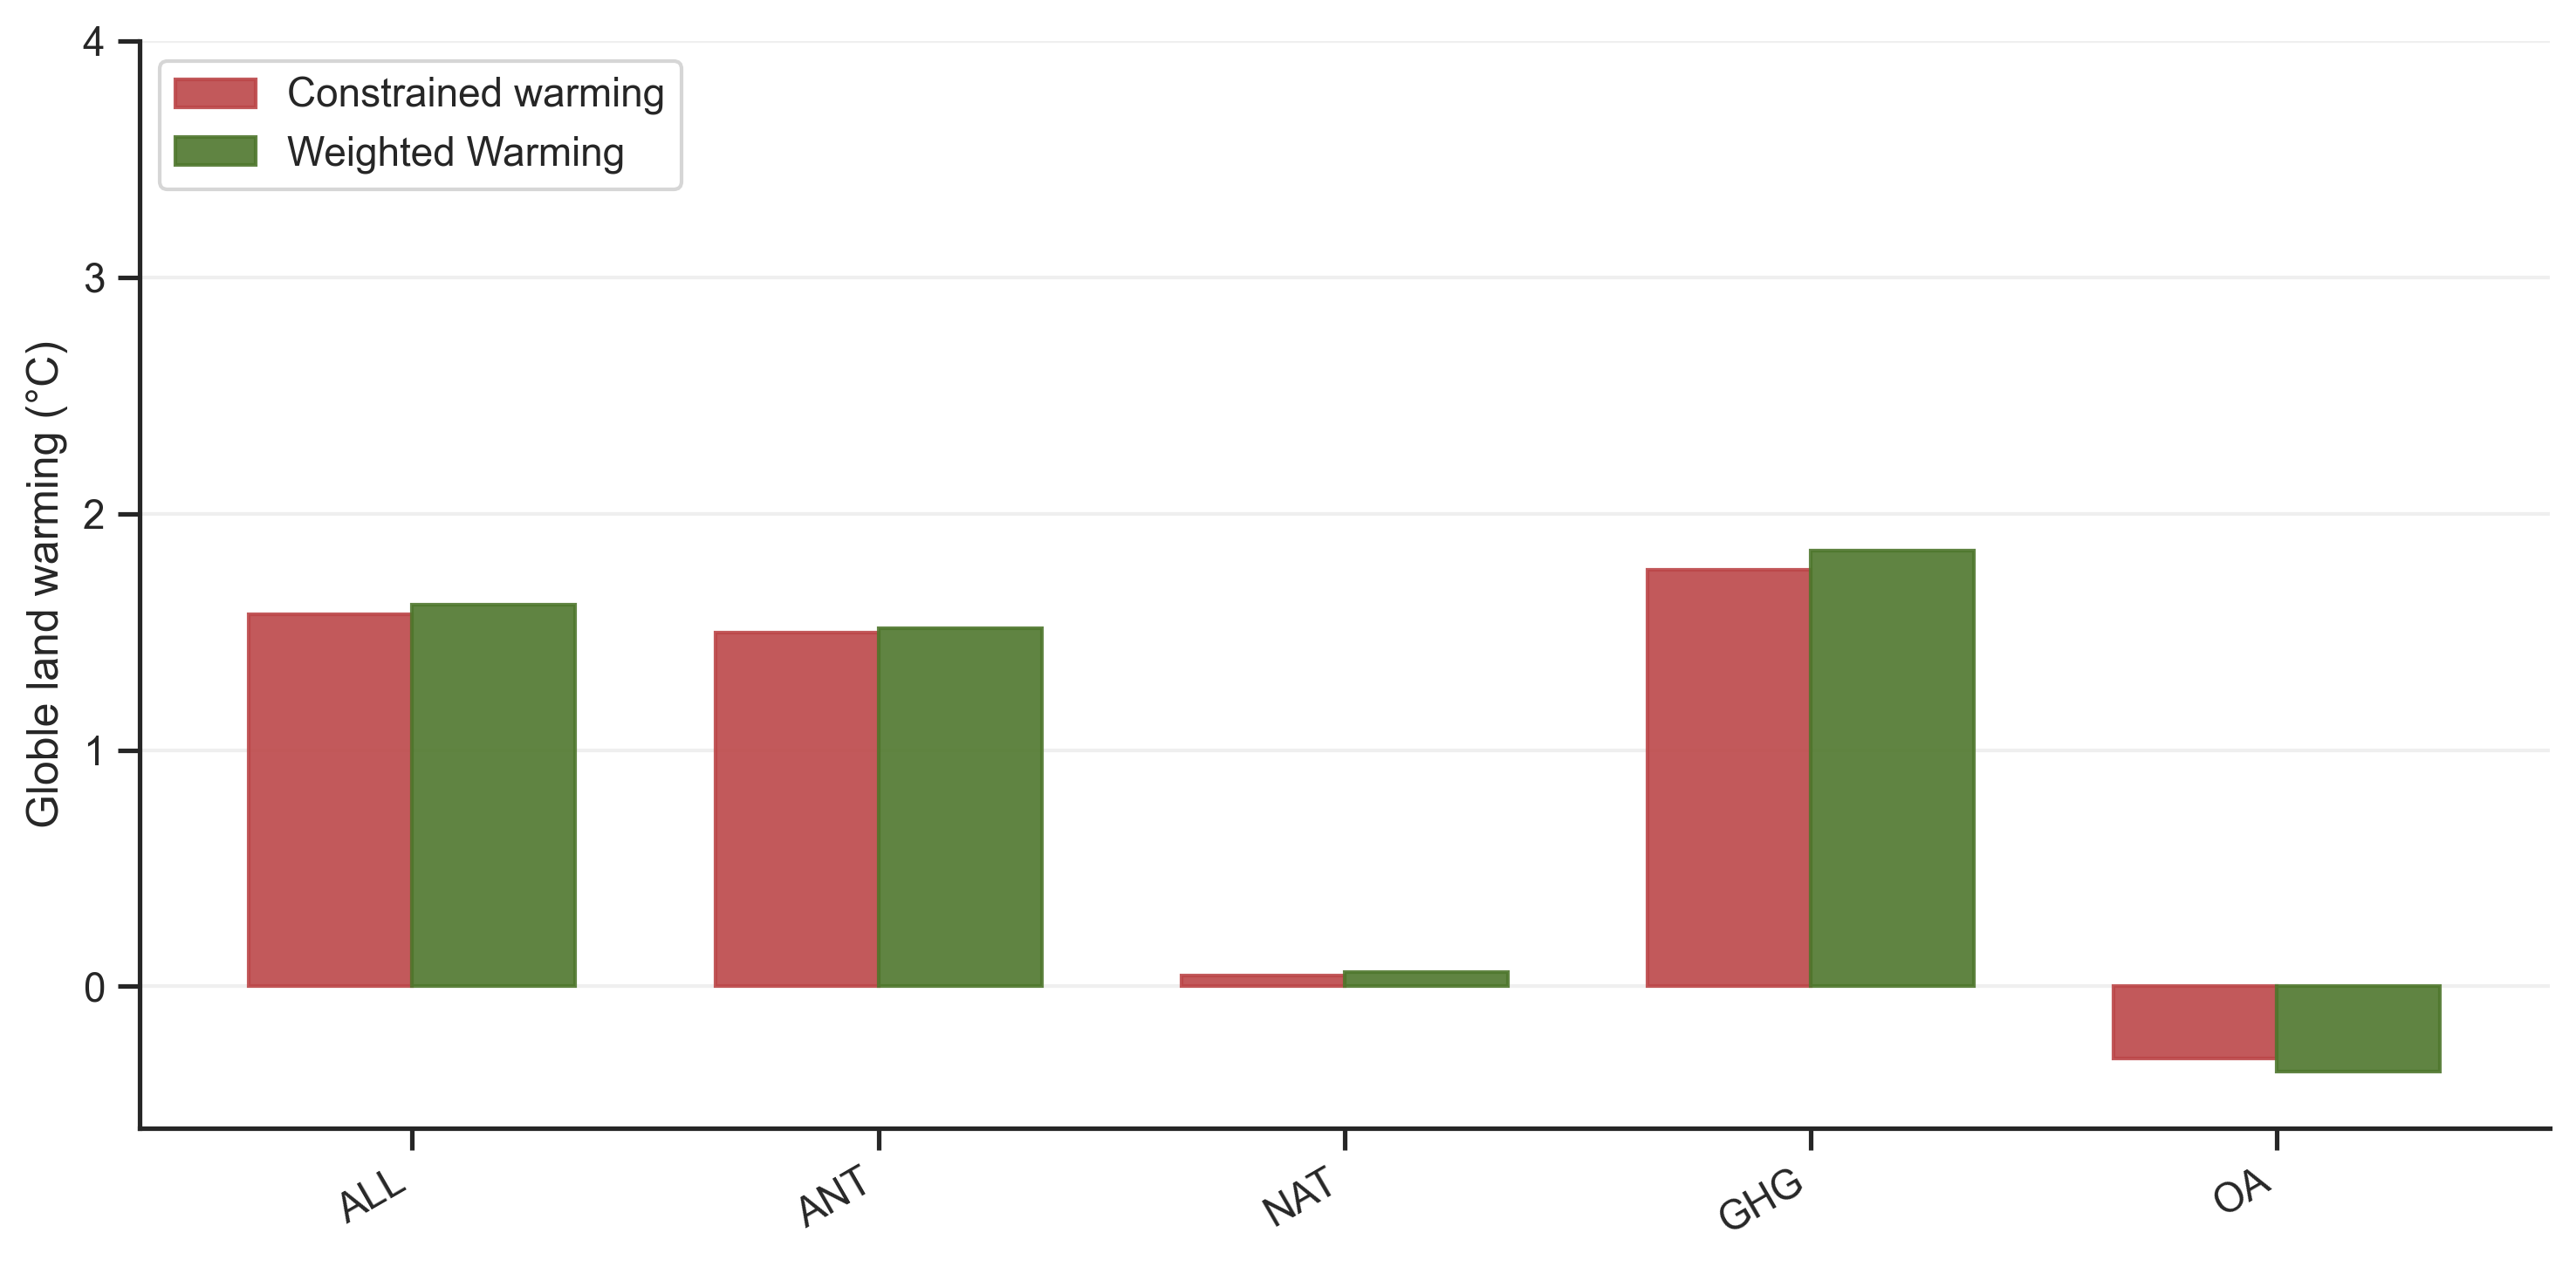

In [98]:
# Example data
da1 = global_constrained_warming
da2 = global_weighted_warming

forcings = da1.forcing.values  # or da1.region.values
x = np.arange(len(forcings))
width = 0.35  # bar width

# Compute central value and error
def get_values_and_error(da):
    mean = da.sel(quantile='mean').values
    err_low = mean - da.sel(quantile='5th').values
    err_high = da.sel(quantile='95th').values - mean
    err = np.vstack([err_low, err_high])
    return mean, err

mean1, err1 = get_values_and_error(da1)
mean2, err2 = get_values_and_error(da2)

# Create figure
fig, ax = plt.subplots(figsize=(10,5), dpi = 300)

# Plot bars with error bars
ax.bar(x - width/2, mean1, width, capsize=5, label='Constrained warming', 
       color='#bc4749', alpha=0.9, edgecolor='#bc4749')
ax.bar(x + width/2, mean2, width, capsize=5, label='Weighted Warming', 
       color='#4f772d', alpha=0.9, edgecolor='#4f772d')

# Labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(forcings, rotation=30, ha='right')
ax.set_ylabel('Globle land warming (°C)')
# ax.set_title('Warming comparison by region')
ax.grid(axis='y', alpha=0.3)
ax.legend(loc = 'upper left')
ax.set_ylim(-0.6, 4.0)

plt.tight_layout()
plt.show()

In [57]:
uncertainty_ref_period=(1850, 2025)
ref_period=(1850, 2025)
obs_adjust_ref_period=(1961, 2023)
warming_target_period=(2016, 2025)

In [59]:
def plot_forcing_panels(
    sel_forcing,
    regions,
    prior_smooth,
    post_smooth,
    obs_adjust,
    ref_period,
    ncols=8,
    figsize=(40, 20),
    ylim=(-2, 4)
):
    """
    Plot attributable warming time series for each region under a given forcing.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    n_panels = len(regions)
    nrows = (n_panels + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=300)
    axes = axes.flatten()

    sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

    for i, sel_region in enumerate(regions):
        ax = axes[i]

        # Select from Dataset
        prior = prior_post_smooth.sel(scheme = 'prior', region=prior_post_smooth['names'] == sel_region, forcing=sel_forcing).squeeze(dim='region')
        post = prior_post_smooth.sel(scheme = 'post', region=post_smooth['names'] == sel_region, forcing=sel_forcing).squeeze(dim='region')
        obs = obs_adjust.sel(region=obs_adjust['names'] == sel_region, forcing=sel_forcing).squeeze(dim='region')

        plot_line_shades(ax, prior, 'gray', 'Prior')
        plot_line_shades(ax, post, '#9b2226', 'Posterior')

        ax.scatter(obs['year'], obs, label='obs', zorder=3, s = 15)
        ax.set_title(sel_region)
        plot_res(ax, *ylim)

    # Hide unused axes
    for j in range(len(regions), len(axes)):
        fig.delaxes(axes[j])

    main_title = f"Attributable warming series to {sel_forcing} forcing\n(ref: {ref_period[0]}–{ref_period[1]})"
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

def plot_res(ax, ymin, ymax):

    ax.set_ylim(ymin, ymax)
    # plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # ax.set_ylabel('Temperature responses (°C)',fontsize = 18)  
    ax.legend(fontsize=12,  loc = 'upper left')

    # ax.set_title(title, loc='left', fontsize=20,
    #                 fontdict={'size': 'large', 'weight': 'bold'})

    plt.axhline(y=[0], c='gray', lw=3.0, alpha = 0.5, ls = 'dashed')



region_names = prior_warm_forcing_5_adj['names'].values
for sel_forcing in ['ALL']:
    plot_forcing_panels(
        sel_forcing,
        region_names,
        prior_smooth_forcing_5_adj.sel(forcing = ['ALL']),
        post_smooth_forcing_5_adj.sel(forcing = ['ALL']),
        obs_adj_ALL,
        ref_period
    )

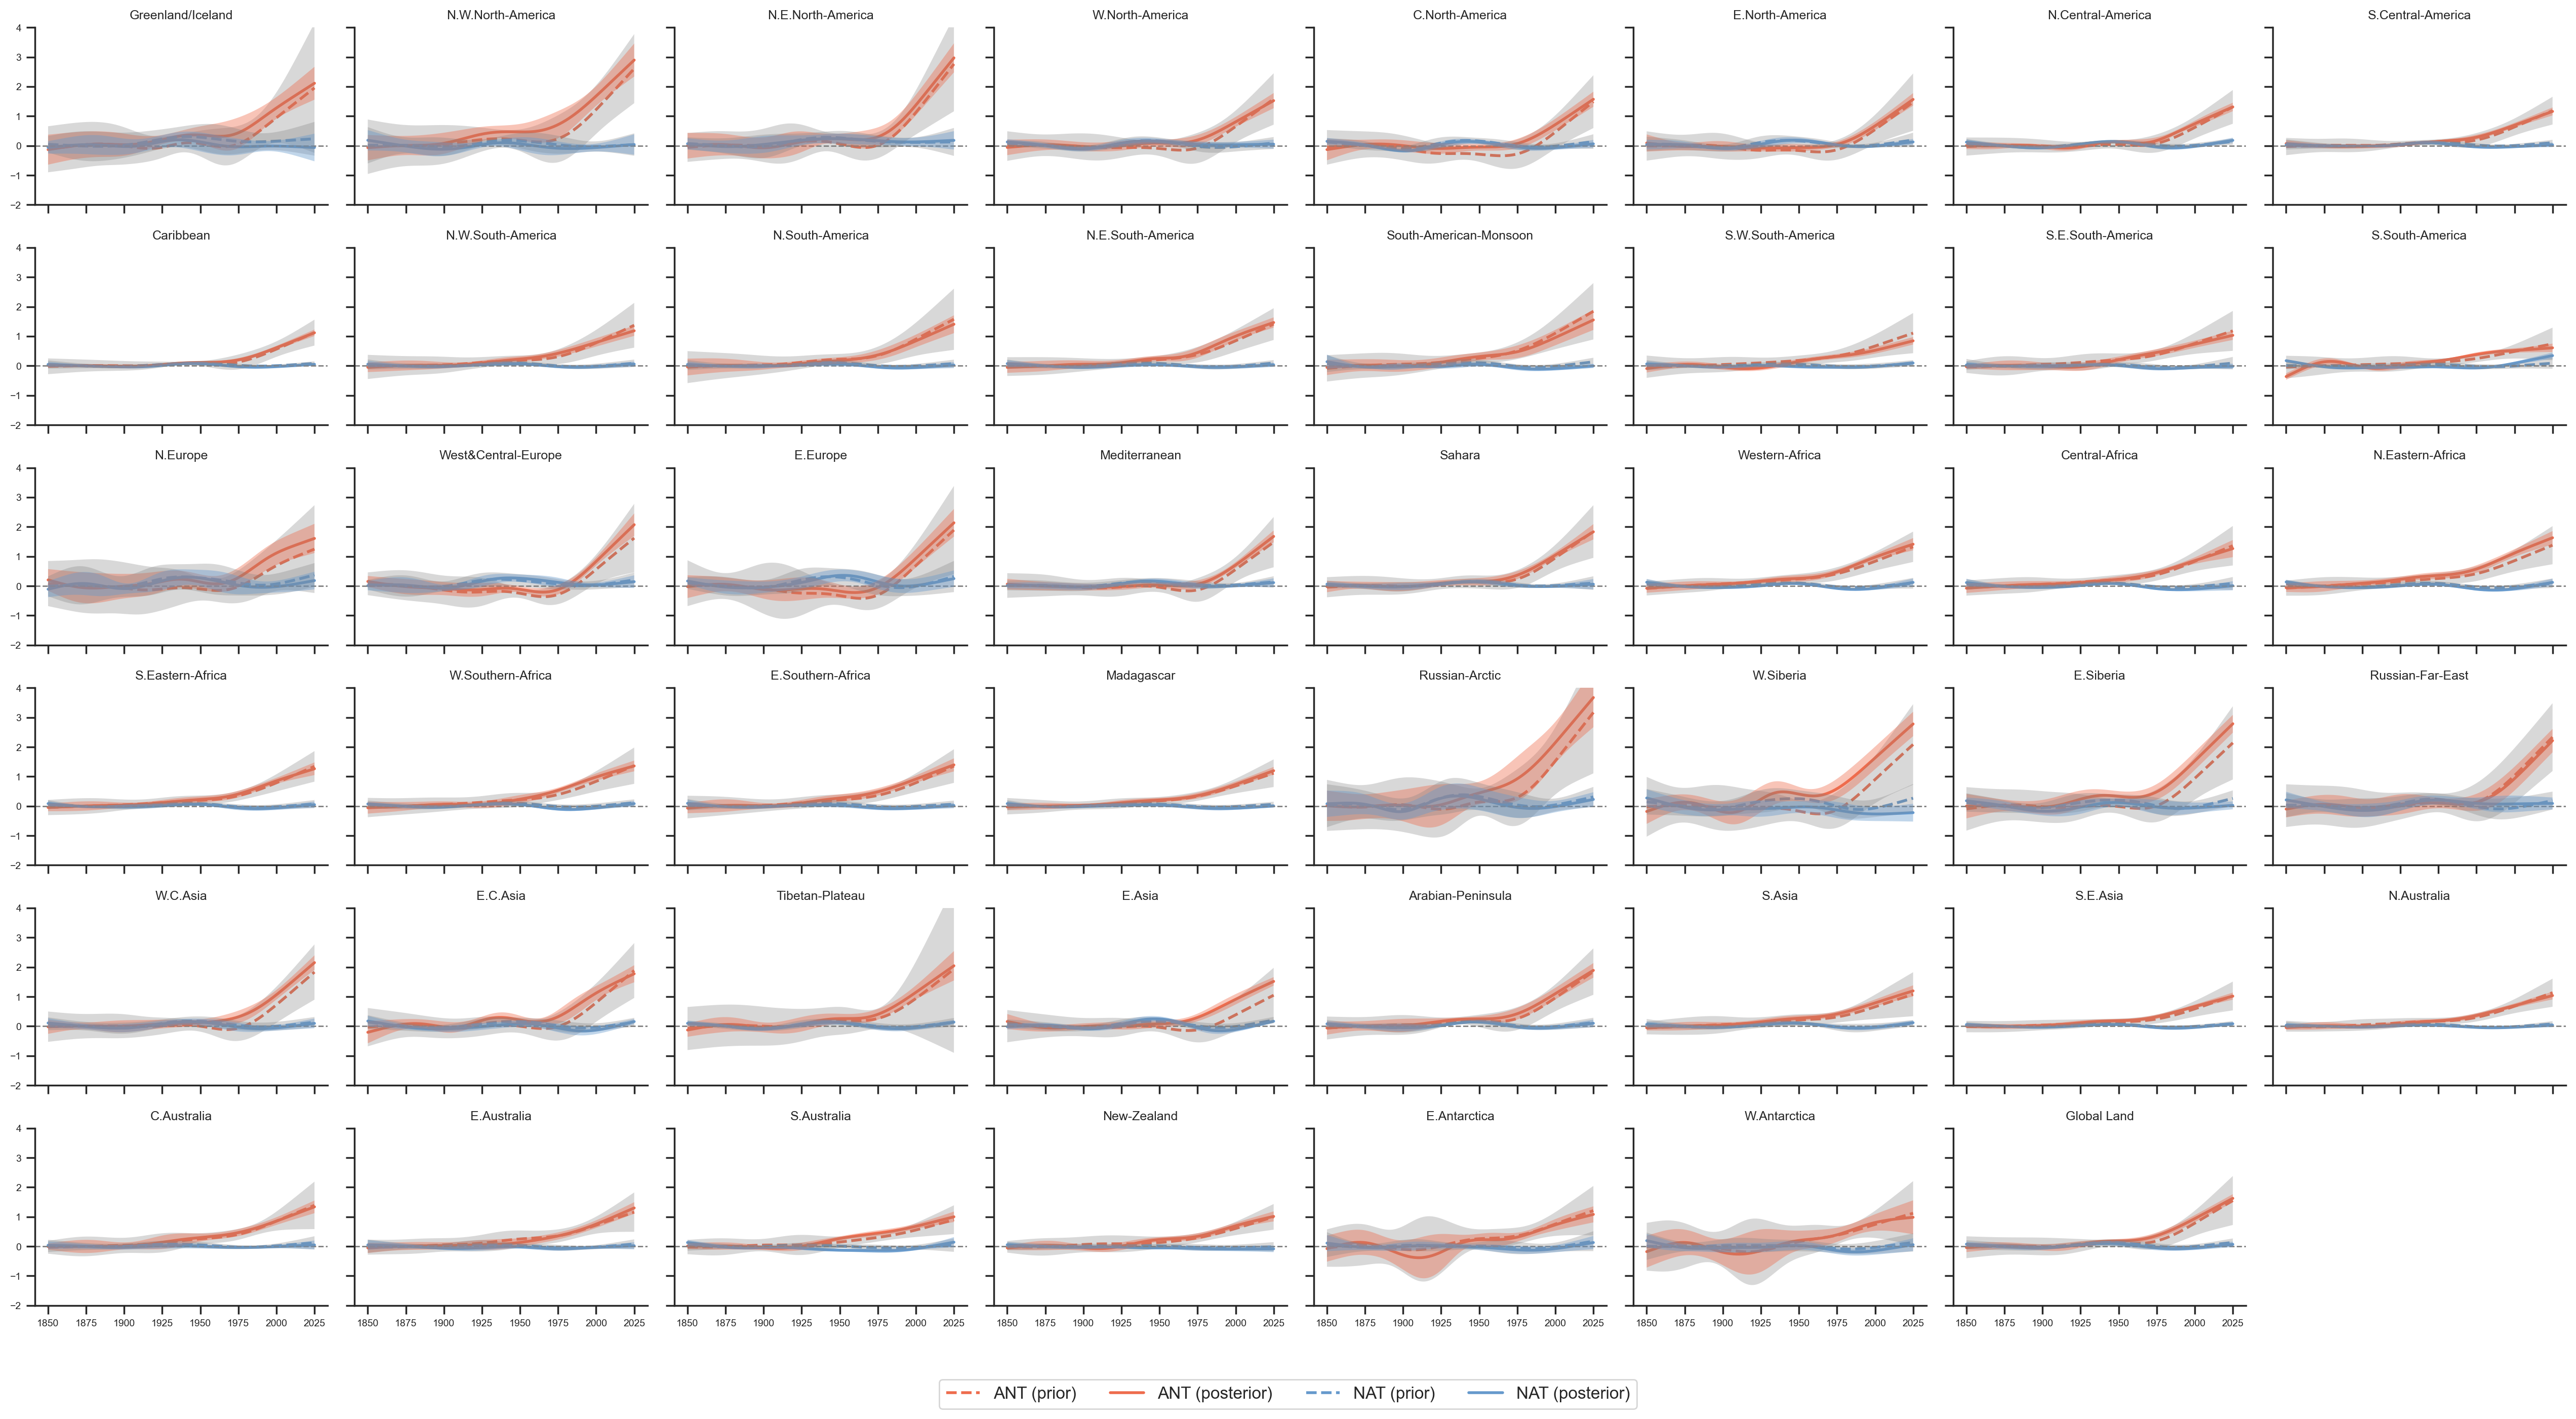

In [83]:
colors_forcings = ['#a23e48', '#ee6c4d', '#6699CC', '#F5CB5C', '#4C956C']  # 'ALL' 'ANT' 'NAT' 'GHG' 'OA'


# Parameters
nrows, ncols = 6, 8
fig, axes = plt.subplots(nrows, ncols, figsize=(3.2 * ncols, 2.3 * nrows), dpi=200, sharex=True, sharey=True)
axes = axes.flatten()

# For collecting legend handles (only from first region)
legend_lines = []
legend_labels = []

for r_id, ax in enumerate(axes):
    if r_id >= len(region_names):
        ax.axis('off')
        continue

    data1 = prior_post_smooth.sel(scheme = 'prior')[r_id].sel(forcing=['ANT', 'NAT'])
    data2 = prior_post_smooth.sel(scheme = 'post')[r_id].sel(forcing=['ANT', 'NAT'])
    forcings1 = data1.forcing.values
    colors1 = ['#ee6c4d', '#6699CC']

    for i, forcing in enumerate(forcings1):
        # Individual
        line1, = ax.plot(data1['year'], data1.sel(quantile='mean')[i, :], linestyle='--', color=colors1[i], lw = 2)
        # Sum
        line2, = ax.plot(data2['year'], data2.sel(quantile='mean')[i, :], linestyle='-', color=colors1[i], lw = 2)
        
        # Shading
        plot_shading(ax, data1['year'], data1.sel(quantile='5th')[i, :], data1.sel(quantile='95th')[i, :], color='gray', alpha=0.3)
        plot_shading(ax, data2['year'], data2.sel(quantile='5th')[i, :], data2.sel(quantile='95th')[i, :], color=colors1[i], alpha=0.4)

        if r_id == 0:
            legend_lines.extend([line1, line2])
            legend_labels.extend([f'{forcing} (prior)', f'{forcing} (posterior)'])

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(-2, 4)
    ax.set_title(region_names[r_id], fontsize=9)
    ax.tick_params(labelsize=7)

# Add global legend below the plots
fig.legend(
    handles=legend_lines,
    labels=legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=5,
    fontsize=12
)

plt.tight_layout()  # Leave space at bottom for legend
plt.subplots_adjust(bottom=0.06)  # Fine-tune the bottom space

plt.show() 

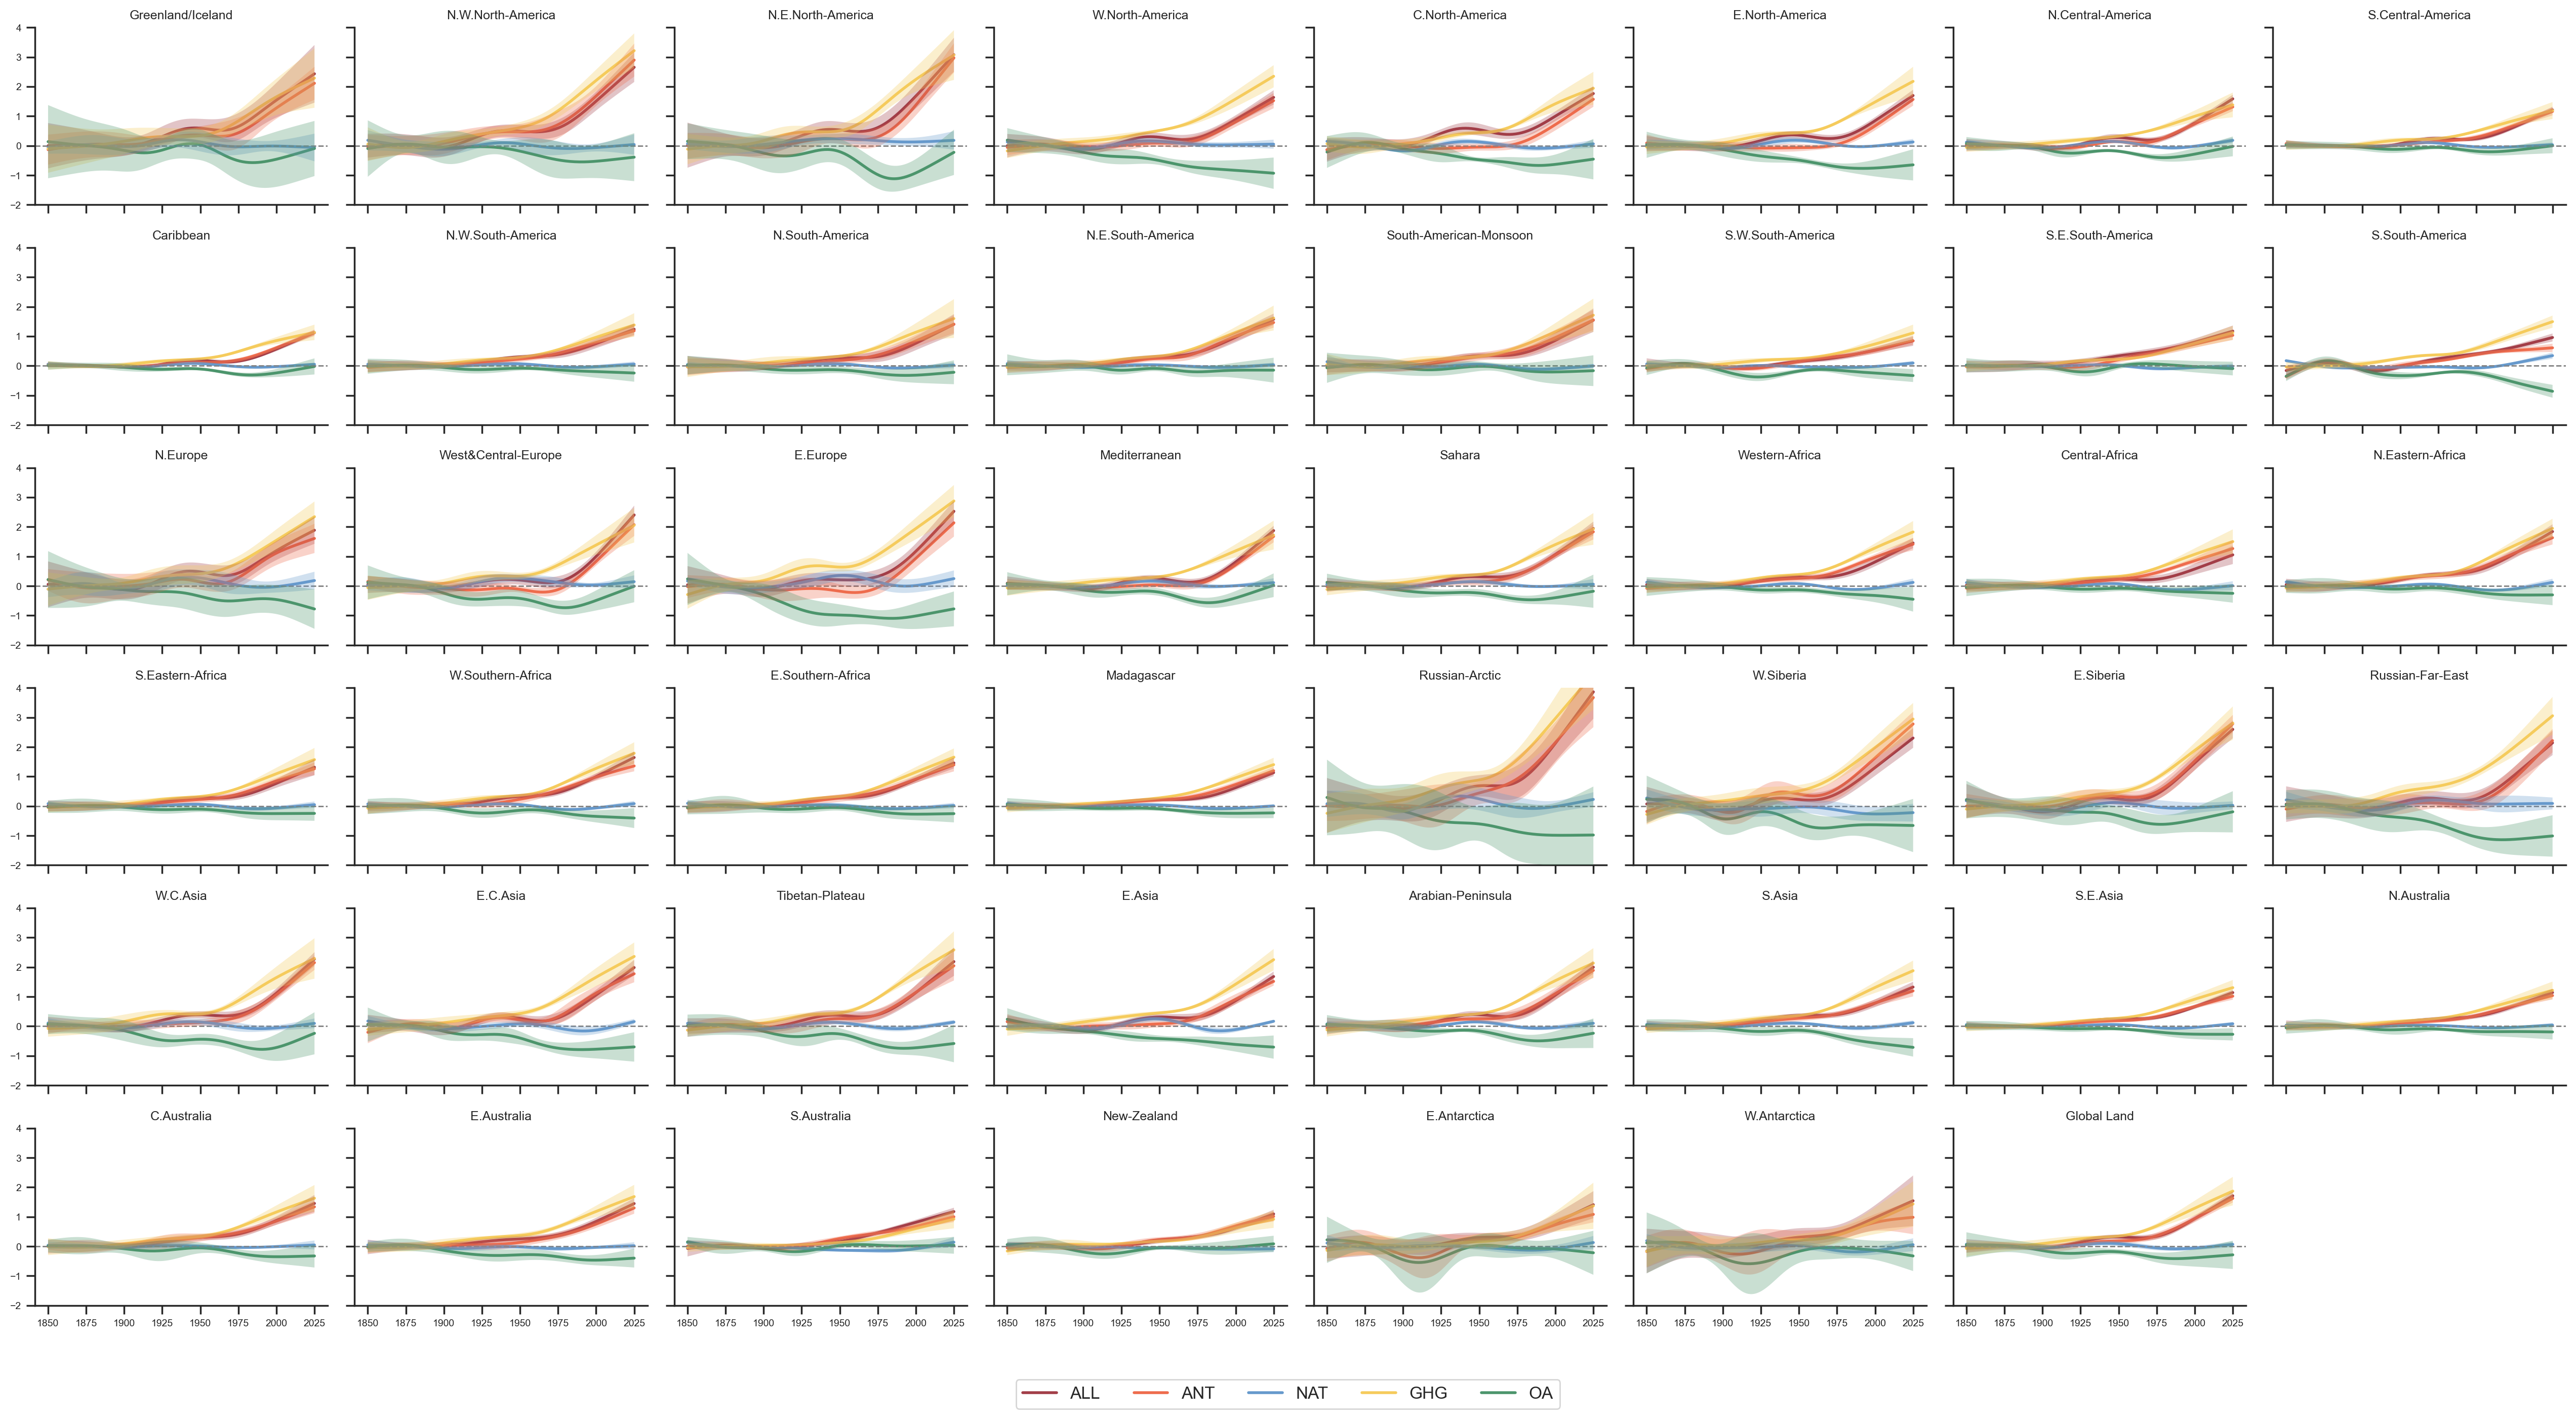

In [82]:
# Parameters
nrows, ncols = 6, 8
fig, axes = plt.subplots(nrows, ncols, figsize=(3.2 * ncols, 2.3 * nrows), dpi=200, sharex=True, sharey=True)
axes = axes.flatten()

# For collecting legend handles (only from first region)
legend_lines = []
legend_labels = []

for r_id, ax in enumerate(axes):
    if r_id >= len(region_names):
        ax.axis('off')
        continue

    data1 = prior_post_smooth.sel(scheme = 'prior')[r_id]
    data2 = prior_post_smooth.sel(scheme = 'post')[r_id]
    forcings1 = data1.forcing.values

    for i, forcing in enumerate(forcings1):
        # Individual
        # line1, = ax.plot(data1['year'], data1.sel(quantile='mean')[i, :], linestyle='--', color=colors1[i])
        # Sum
        line2, = ax.plot(data2['year'], data2.sel(quantile='mean')[i, :], linestyle='-', color=colors_forcings[i], lw = 2)
        
        # Shading
        # plot_shading(ax, data1['year'], data1.sel(quantile='5th')[i, :], data1.sel(quantile='95th')[i, :], color='gray', alpha=0.2)
        plot_shading(ax, data2['year'], data2.sel(quantile='5th')[i, :], data2.sel(quantile='95th')[i, :], color=colors_forcings[i], alpha=0.3)

        if r_id == 0:
            legend_lines.extend([line2])
            legend_labels.extend([f'{forcing}'])

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(-2, 4)
    ax.set_title(region_names[r_id], fontsize=9)
    ax.tick_params(labelsize=7)

# Add global legend below the plots
fig.legend(
    handles=legend_lines,
    labels=legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=5,
    fontsize=12
)

plt.tight_layout()  # Leave space at bottom for legend
plt.subplots_adjust(bottom=0.06)  # Fine-tune the bottom space

plt.show() 